### Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/My Drive/Colab Notebooks/CV assessment/Dataset'

In [ ]:
import os
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
if not os.path.exists(dataset_path):
    print(f"Dataset path does not exist: {dataset_path}")
else:
    print(f"Dataset path exists: {dataset_path}")
    classes = os.listdir(dataset_path)
    print(f"Classes found: {classes}")

Dataset path exists: /content/drive/My Drive/Colab Notebooks/CV assessment/Dataset
Classes found: ['CLL', 'AML', 'MM', 'CML', 'Healthy', 'ALL']


### Set the seed for reproducibility

In [ ]:
seed_value = 0
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

In [ ]:
base_dir = '/content/dataset_split/'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

### Function to split data

In [ ]:
def split_data(dataset_path, train_size=0.6, val_size=0.2, test_size=0.2):
    """Split dataset into train, validation, and test sets."""
    classes = os.listdir(dataset_path)  # Get class names

    # Create directories if they don't exist
    for directory in [train_dir, val_dir, test_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)  # Create the main directory

    for cls in classes:
        # Create class directories in train, validation, and test directories
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

        class_path = os.path.join(dataset_path, cls)
        images = os.listdir(class_path)

        # Split into train, validation, and test sets
        train_images, temp_images = train_test_split(images, train_size=train_size, random_state=seed_value)
        val_images, test_images = train_test_split(temp_images, test_size=test_size/(val_size + test_size), random_state=seed_value)

        # Move images to respective directories
        for image in train_images:
            src = os.path.join(class_path, image)
            dst = os.path.join(train_dir, cls, image)
            try:
                print(f"Copying {src} to {dst}")  # Debugging statement
                shutil.copy(src, dst)
            except Exception as e:
                print(f"Error copying {src} to {dst}: {e}")

        for image in val_images:
            src = os.path.join(class_path, image)
            dst = os.path.join(val_dir, cls, image)
            try:
                print(f"Copying {src} to {dst}")  # Debugging statement
                shutil.copy(src, dst)
            except Exception as e:
                print(f"Error copying {src} to {dst}: {e}")

        for image in test_images:
            src = os.path.join(class_path, image)
            dst = os.path.join(test_dir, cls, image)
            try:
                print(f"Copying {src} to {dst}")  # Debugging statement
                shutil.copy(src, dst)
            except Exception as e:
                print(f"Error copying {src} to {dst}: {e}")

### Split the dataset into train, validation, and test sets

In [ ]:
split_data(dataset_path)

Copying /content/drive/My Drive/Colab Notebooks/CV assessment/Dataset/CLL/62501_output_output (7).jpg to /content/dataset_split/train/CLL/62501_output_output (7).jpg
Copying /content/drive/My Drive/Colab Notebooks/CV assessment/Dataset/CLL/63351_output_output (3).jpg to /content/dataset_split/train/CLL/63351_output_output (3).jpg
Copying /content/drive/My Drive/Colab Notebooks/CV assessment/Dataset/CLL/CLL 62202_output_output.jpg to /content/dataset_split/train/CLL/CLL 62202_output_output.jpg
Copying /content/drive/My Drive/Colab Notebooks/CV assessment/Dataset/CLL/61675_output_output_output.jpg to /content/dataset_split/train/CLL/61675_output_output_output.jpg
Copying /content/drive/My Drive/Colab Notebooks/CV assessment/Dataset/CLL/63326_output_output (6).jpg to /content/dataset_split/train/CLL/63326_output_output (6).jpg
Copying /content/drive/My Drive/Colab Notebooks/CV assessment/Dataset/CLL/62204_output.jpg to /content/dataset_split/train/CLL/62204_output.jpg
Copying /content/dri

### Data augmentation with ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'  # Fill pixels that are newly created after shifting/rotation
)

In [ ]:
train_data = datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')
val_data = datagen.flow_from_directory(val_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')
test_data = datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=32, class_mode='categorical')

Found 1440 images belonging to 6 classes.
Found 480 images belonging to 6 classes.
Found 480 images belonging to 6 classes.


### Function to display images in a grid

In [ ]:
def display_images(images, labels, class_names, title):
    """Display a grid of images with their corresponding labels."""
    plt.figure(figsize=(12, 8))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])  # Display the class name of the image
        plt.axis('off')
    plt.suptitle(title, fontsize=20)
    plt.show()

### Display a batch of training images

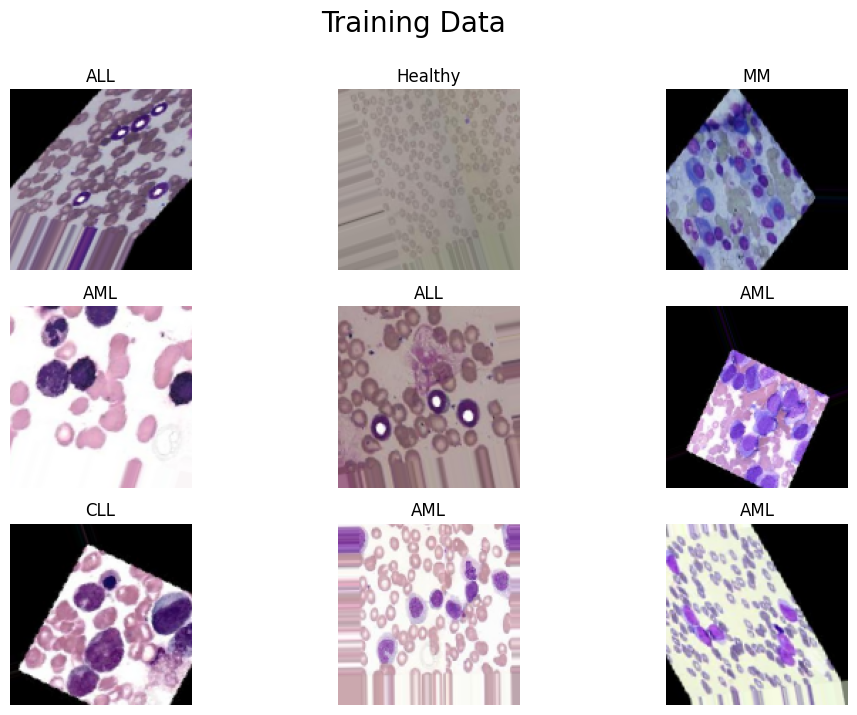

In [ ]:
training_images, training_labels = next(train_data)
class_names = list(train_data.class_indices.keys())
display_images(training_images, training_labels, class_names, "Training Data")

### Display a batch of validation images

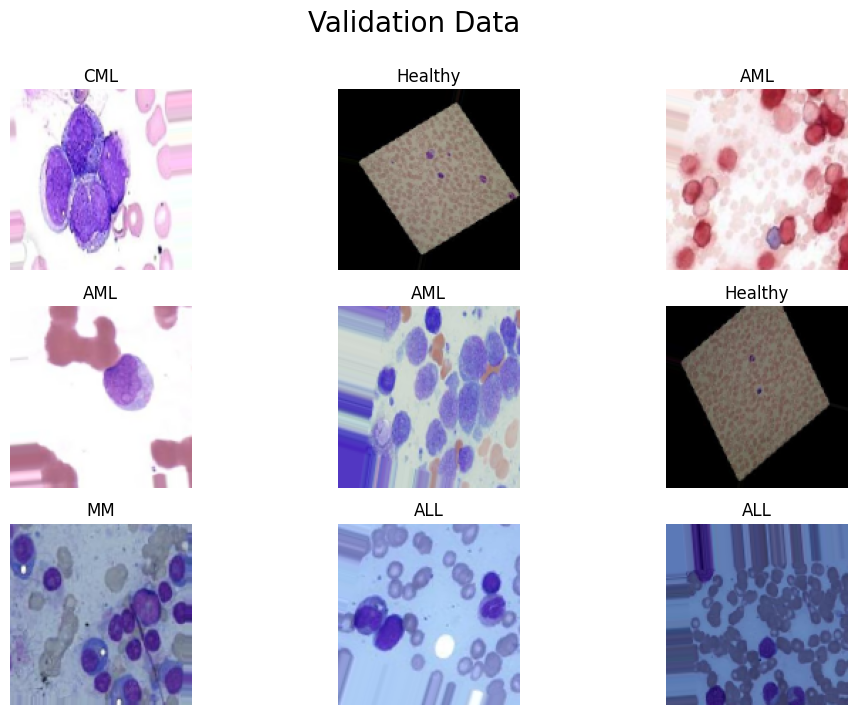

In [ ]:
validation_images, validation_labels = next(val_data)
display_images(validation_images, validation_labels, class_names, "Validation Data")

### Display a batch of test images

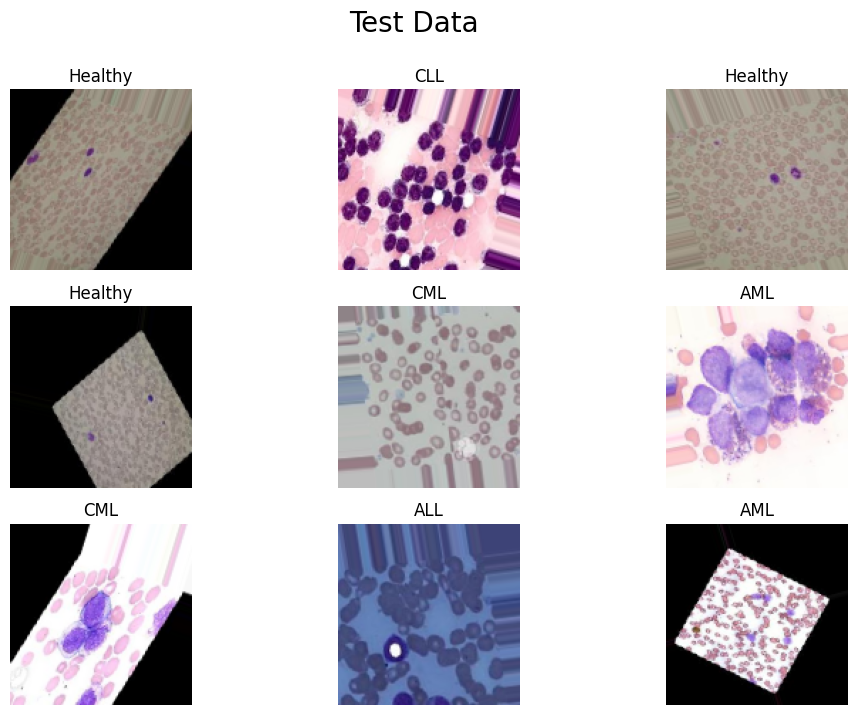

In [ ]:
test_images, test_labels = next(test_data)
display_images(test_images, test_labels, class_names, "Test Data")

### Early stopping and learning rate reduction for better training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

### CNN Model

In [ ]:
def build_cnn_model(learning_rate=1e-4, dropout_rate=0.5):
    cnn_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(6, activation='softmax')
    ])
    cnn_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return cnn_model

In [ ]:
# Set specific hyperparameters
learning_rate = 1e-4
dropout_rate = 0.3

# Print training information
print(f"Training CNN with learning rate: {learning_rate} and dropout: {dropout_rate}")

# Build and train the CNN model
cnn_model = build_cnn_model(learning_rate=learning_rate, dropout_rate=dropout_rate)
cnn_history = cnn_model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[early_stopping, reduce_lr])

Training CNN with learning rate: 0.0001 and dropout: 0.3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - accuracy: 0.1774 - loss: 1.7973 - val_accuracy: 0.2188 - val_loss: 1.6979 - learning_rate: 1.0000e-04
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.2880 - loss: 1.6622 - val_accuracy: 0.3750 - val_loss: 1.4877 - learning_rate: 1.0000e-04
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 234ms/step - accuracy: 0.3726 - loss: 1.4832 - val_accuracy: 0.4187 - val_loss: 1.3928 - learning_rate: 1.0000e-04
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - accuracy: 0.3568 - loss: 1.4400 - val_accuracy: 0.4479 - val_loss: 1.2980 - learning_rate: 1.0000e-04
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.4514 - loss: 1.2868 - val_accuracy: 0.4271 - val_loss: 1.2575 - learning_rate: 1.0000e-04
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.4404 - loss: 1.2542 - val_accuracy: 0.4938 - val_loss: 1.1658 - learning_rate: 1.0000e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.52

In [ ]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,825,684 (148.11 MB)

 Trainable params: 12,941,894 (49.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,883,790 (98.74 MB)

#### Evaluate CNN Model

In [ ]:
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(test_data)
print(f'CNN Test Accuracy: {test_acc_cnn * 100:.2f}%')

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.6053 - loss: 0.8909
CNN Test Accuracy: 61.67%


### VGG16 Model (Transfer Learning)

In [ ]:
def build_vgg_model(learning_rate=1e-4, dropout_rate=0.5):
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    vgg_base.trainable = False
    vgg_model = Sequential([
        vgg_base,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(6, activation='softmax')
    ])
    vgg_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return vgg_model

#### Train VGG16 with fine-tuning

In [ ]:
vgg_model = build_vgg_model()
vgg_history = vgg_model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[early_stopping, reduce_lr])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 416s 9s/step - accuracy: 0.2112 - loss: 1.9054 - val_accuracy: 0.3688 - val_loss: 1.6525 - learning_rate: 1.0000e-04
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 414s 9s/step - accuracy: 0.2628 - loss: 1.7290 - val_accuracy: 0.4792 - val_loss: 1.5452 - learning_rate: 1.0000e-04
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 477s 10s/step - accuracy: 0.3381 - loss: 1.6185 - val_accuracy: 0.5063 - val_loss: 1.4598 - learning_rate: 1.0000e-04
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 462s 9s/step - accuracy: 0.4152 - loss: 1.5107 - val_accuracy: 0.5417 - val_loss: 1.3663 - learning_rate: 1.0000e-04
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 407s 9s/step - accuracy: 0.4604 - loss: 1.3994 - val_accuracy: 0.5417 - val_loss: 1.3233 - learning_rate: 1.0000e-04


#### Fine-tune VGG16

In [ ]:
vgg_model.layers[0].trainable = True
vgg_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 288ms/step - accuracy: 0.2927 - loss: 1.6580 - val_accuracy: 0.5938 - val_loss: 1.1066 - learning_rate: 1.0000e-05
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 265ms/step - accuracy: 0.5557 - loss: 1.1229 - val_accuracy: 0.6938 - val_loss: 0.7519 - learning_rate: 1.0000e-05
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 244ms/step - accuracy: 0.6572 - loss: 0.8548 - val_accuracy: 0.7604 - val_loss: 0.6125 - learning_rate: 1.0000e-05
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - accuracy: 0.7334 - loss: 0.6628 - val_accuracy: 0.7563 - val_loss: 0.5687 - learning_rate: 1.0000e-05
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - accuracy: 0.7798 - loss: 0.5800 - val_accuracy: 0.7500 - val_loss: 0.5713 - learning_rate: 1.0000e-05
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 264ms/step - accuracy: 0.7566 - loss: 0.5881 - val_accuracy: 0.8021 - val_loss: 0.5283 - learning_rate: 1.0000e-05
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - acc

In [ ]:
vgg_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,941,268 (171.44 MB)

 Trainable params: 14,980,422 (57.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,960,846 (114.29 MB)

#### Evaluate VGG16 Model

In [ ]:
test_loss_vgg, test_acc_vgg = vgg_model.evaluate(test_data)
print(f'VGG16 Test Accuracy: {test_acc_vgg * 100:.2f}%')

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.8443 - loss: 0.4184
VGG16 Test Accuracy: 81.25%


### ResNet50 Model

In [ ]:
def build_resnet_model(learning_rate=1e-4, dropout_rate=0.5):
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    resnet_base.trainable = False
    resnet_model = Sequential([
        resnet_base,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(6, activation='softmax')
    ])
    resnet_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return resnet_model

#### Train ResNet50 model with fine-tuning

In [ ]:
resnet_model = build_resnet_model()
resnet_history = resnet_model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[early_stopping, reduce_lr])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 27s 330ms/step - accuracy: 0.1621 - loss: 2.0441 - val_accuracy: 0.2000 - val_loss: 1.7699 - learning_rate: 1.0000e-04
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 232ms/step - accuracy: 0.1831 - loss: 1.9062 - val_accuracy: 0.2979 - val_loss: 1.7462 - learning_rate: 1.0000e-04
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.1727 - loss: 1.8966 - val_accuracy: 0.3000 - val_loss: 1.7312 - learning_rate: 1.0000e-04
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.1962 - loss: 1.8327 - val_accuracy: 0.3396 - val_loss: 1.7110 - learning_rate: 1.0000e-04
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.2259 - loss: 1.8126 - val_accuracy: 0.3146 - val_loss: 1.6977 - learning_rate: 1.0000e-04


#### Fine-tuning: Unfreeze the last few layers of ResNet50 for fine-tuning

In [ ]:
resnet_model.layers[0].trainable = True
resnet_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 76s 333ms/step - accuracy: 0.2290 - loss: 2.1915 - val_accuracy: 0.1875 - val_loss: 1.8064 - learning_rate: 1.0000e-05
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 49s 216ms/step - accuracy: 0.3994 - loss: 1.6262 - val_accuracy: 0.1667 - val_loss: 1.8267 - learning_rate: 1.0000e-05
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - accuracy: 0.4723 - loss: 1.4088 - val_accuracy: 0.1646 - val_loss: 1.9370 - learning_rate: 1.0000e-05
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 246ms/step - accuracy: 0.5537 - loss: 1.1964 - val_accuracy: 0.1646 - val_loss: 1.9968 - learning_rate: 2.0000e-06
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - accuracy: 0.5773 - loss: 1.1388 - val_accuracy: 0.1667 - val_loss: 2.0888 - learning_rate: 2.0000e-06


In [ ]:
resnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,813,396 (281.58 MB)

 Trainable params: 24,586,758 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 49,173,518 (187.58 MB)

#### Evaluate ResNet50 Model

In [ ]:
test_loss_resnet, test_acc_resnet = resnet_model.evaluate(test_data)
print(f'ResNet50 Test Accuracy: {test_acc_resnet * 100:.2f}%')

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.1931 - loss: 1.8023
ResNet50 Test Accuracy: 18.75%


### Functions to Plot Training History and Confusion Matrix

In [ ]:
def plot_metrics(history, model_name):
    """Plot training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrix(model, test_data, model_name):
    """Plot the confusion matrix."""
    # Get true labels and predicted labels
    y_true = test_data.classes
    y_pred = model.predict(test_data)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### CNN Model Plot Training History and Confusion Matrix

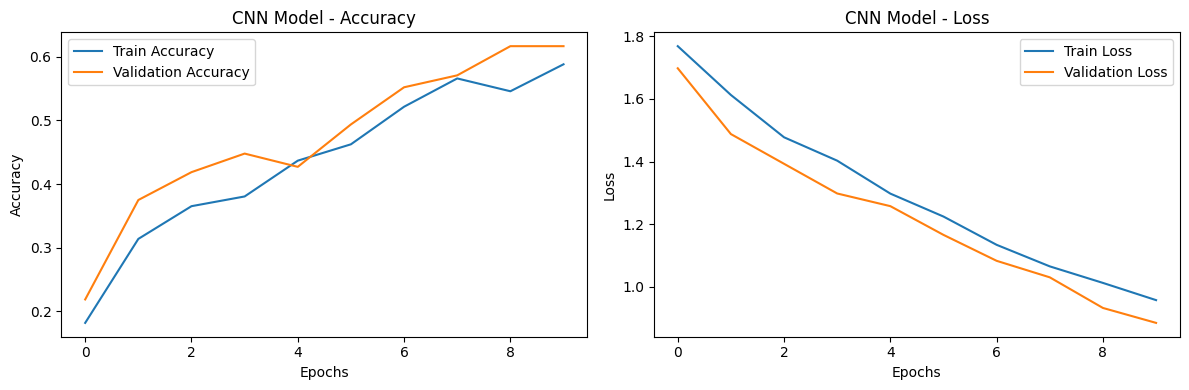

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step


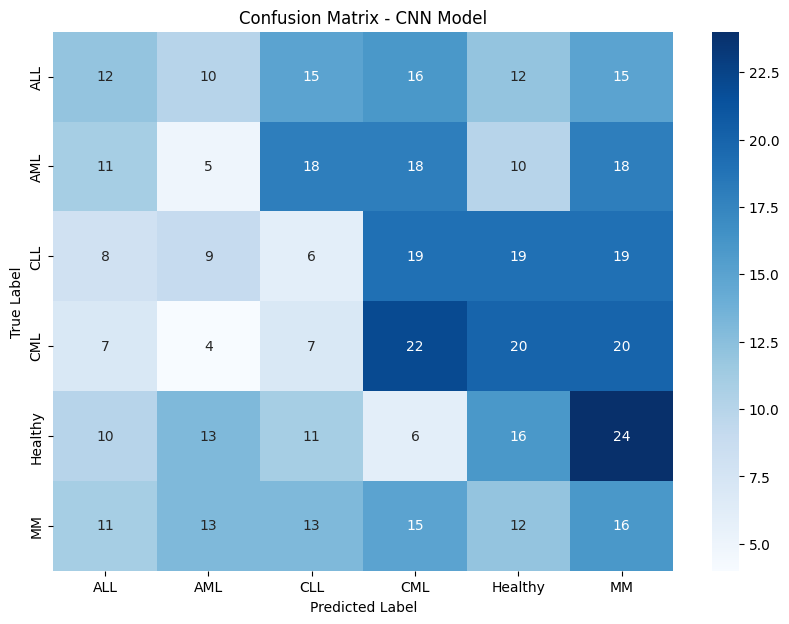

In [ ]:
plot_metrics(cnn_history, model_name="CNN Model")
plot_confusion_matrix(cnn_model, test_data, "CNN Model")

### VGG16 Model Plot Training History and Confusion Matrix

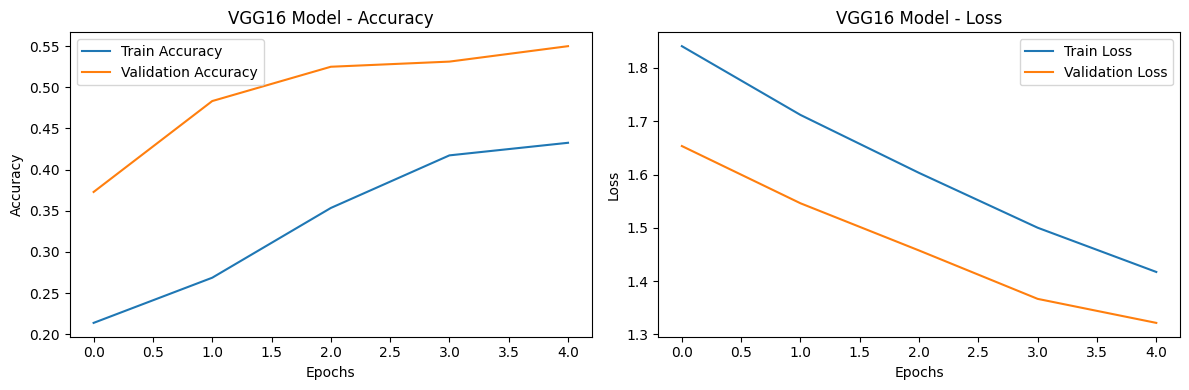

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step


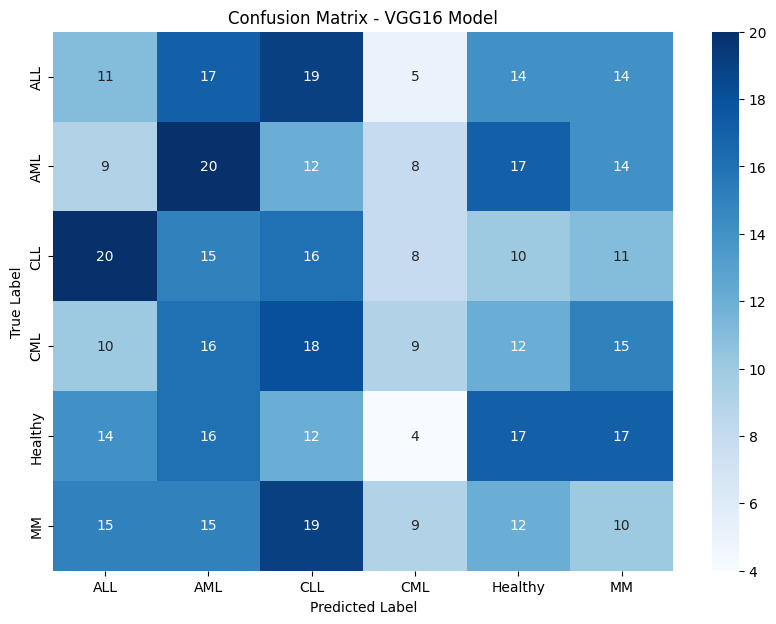

In [ ]:
plot_metrics(vgg_history, "VGG16 Model")
plot_confusion_matrix(vgg_model, test_data, "VGG16 Model")

### ResNet50 Model Plot Training History and Confusion Matrix

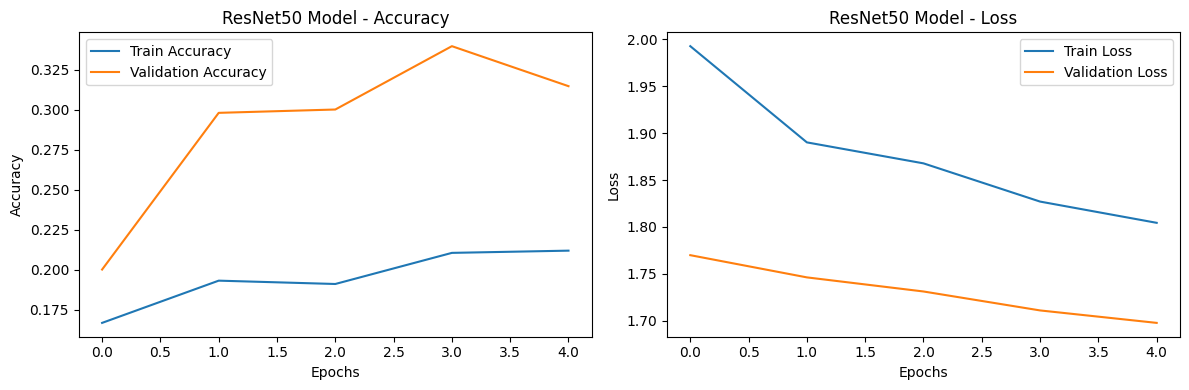

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step


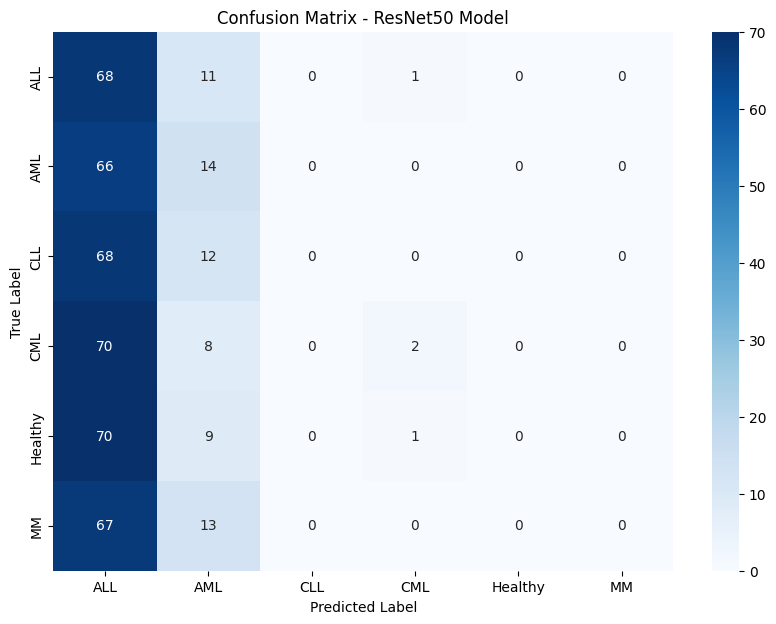

In [ ]:
plot_metrics(resnet_history, "ResNet50 Model")
plot_confusion_matrix(resnet_model, test_data, "ResNet50 Model")

### CNN Classification Report

In [ ]:
y_pred_cnn = cnn_model.predict(test_data)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
print(classification_report(test_data.classes, y_pred_cnn_classes))

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step
              precision    recall  f1-score   support

           0       0.16      0.11      0.13        80
           1       0.16      0.11      0.13        80
           2       0.12      0.11      0.12        80
           3       0.14      0.16      0.15        80
           4       0.21      0.23      0.22        80
           5       0.15      0.21      0.17        80

    accuracy                           0.16       480
   macro avg       0.16      0.16      0.15       480
weighted avg       0.16      0.16      0.15       480



### VGG16 Classification Report

In [ ]:
y_pred_vgg = vgg_model.predict(test_data)
y_pred_vgg_classes = np.argmax(y_pred_vgg, axis=1)
print(classification_report(test_data.classes, y_pred_vgg_classes))

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step
              precision    recall  f1-score   support

           0       0.16      0.16      0.16        80
           1       0.18      0.21      0.19        80
           2       0.15      0.20      0.17        80
           3       0.23      0.10      0.14        80
           4       0.16      0.16      0.16        80
           5       0.15      0.15      0.15        80

    accuracy                           0.16       480
   macro avg       0.17      0.16      0.16       480
weighted avg       0.17      0.16      0.16       480



### ResNet50 Classification Report

In [ ]:
y_pred_resnet = resnet_model.predict(test_data)
y_pred_resnet_classes = np.argmax(y_pred_resnet, axis=1)
print(classification_report(test_data.classes, y_pred_resnet_classes))

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step
              precision    recall  f1-score   support

           0       0.16      0.85      0.27        80
           1       0.14      0.10      0.12        80
           2       0.00      0.00      0.00        80
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00        80
           5       0.00      0.00      0.00        80

    accuracy                           0.16       480
   macro avg       0.05      0.16      0.06       480
weighted avg       0.05      0.16      0.06       480



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Compare the three models

In [ ]:
print("\n--- Model Comparison ---")
print(f'CNN Test Accuracy: {test_acc_cnn * 100:.2f}%')
print(f'VGG16 Test Accuracy: {test_acc_vgg * 100:.2f}%')
print(f'ResNet50 Test Accuracy: {test_acc_resnet * 100:.2f}%')

# Determine the best model based on accuracies
best_model = ""
best_accuracy = 0

# Compare accuracies
if test_acc_cnn > test_acc_vgg and test_acc_cnn > test_acc_resnet:
    best_model = "CNN"
    best_accuracy = test_acc_cnn
elif test_acc_vgg > test_acc_cnn and test_acc_vgg > test_acc_resnet:
    best_model = "VGG16"
    best_accuracy = test_acc_vgg
else:
    best_model = "ResNet50"
    best_accuracy = test_acc_resnet

# Print the best model and its accuracy
print(f"--- Best Model Comparison ---")
print(f"The best model is: {best_model} with an accuracy of: {best_accuracy * 100:.2f}%")


--- Model Comparison ---
CNN Test Accuracy: 61.67%
VGG16 Test Accuracy: 81.25%
ResNet50 Test Accuracy: 18.75%
--- Best Model Comparison ---
The best model is: VGG16 with an accuracy of: 81.25%
